In [47]:
# Imports 
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import SMOTE
from torch.optim import lr_scheduler
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
# Load and prepare the data
df = pd.read_csv(r"C:\Users\andre\Downloads\archive\healthcare-dataset-stroke-data.csv")

# Remove samples where gender is "Other"
df = df[df['gender'] != 'Other']

# Handle missing values
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# Convert categorical variables to numeric
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})  
df['ever_married'] = df['ever_married'].map({'No': 0, 'Yes': 1})
work_type_dummies = pd.get_dummies(df['work_type'], drop_first=True)
df = pd.concat([df.drop('work_type', axis=1), work_type_dummies], axis=1)
df['Residence_type'] = df['Residence_type'].map({'Rural': 0, 'Urban': 1})
smoking_status_dummies = pd.get_dummies(df['smoking_status'], drop_first=True)
df = pd.concat([df.drop('smoking_status', axis=1), smoking_status_dummies], axis=1)

# Select features
features = ['age', 'gender', 'hypertension', 'heart_disease', 'ever_married',
           'Residence_type', 'avg_glucose_level', 'bmi',
           'Private', 'Self-employed', 'children', 'Never_worked',  # work_type features
           'formerly smoked', 'never smoked', 'smokes']  # smoking_status features
X = df[features]
y = df['stroke']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  w

Accuracy: 0.7407

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       960
           1       0.17      0.81      0.27        62

    accuracy                           0.74      1022
   macro avg       0.57      0.77      0.56      1022
weighted avg       0.93      0.74      0.81      1022



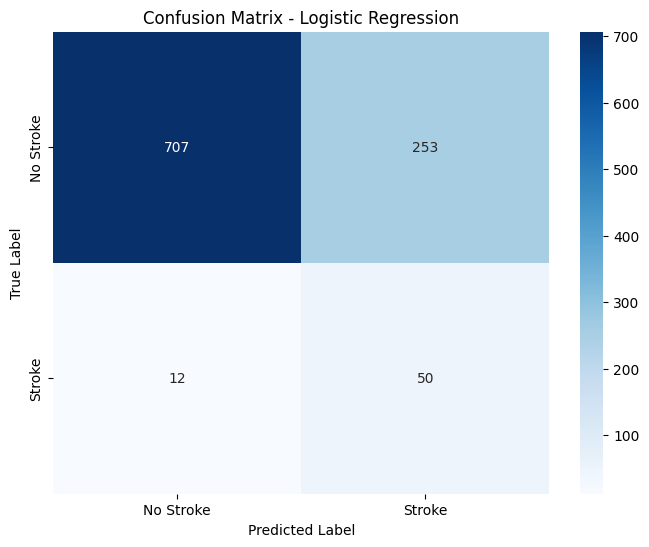


Feature Importance:
              Feature  Importance
0                 age    2.111724
10           children    0.597542
6   avg_glucose_level    0.217856
8             Private    0.146980
14             smokes    0.113803
2        hypertension    0.098446
1              gender    0.057844
3       heart_disease    0.037269
7                 bmi    0.010567
5      Residence_type    0.003038
4        ever_married   -0.022664
12    formerly smoked   -0.065747
9       Self-employed   -0.074592
11       Never_worked   -0.100015
13       never smoked   -0.130751


In [40]:
# logistic regression
# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_binary = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Create and display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.coef_[0]
})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Importance', ascending=False))

In [41]:
# Convert numpy arrays to PyTorch tensors
X_train_balanced = torch.FloatTensor(X_train_balanced)
y_train_balanced = torch.FloatTensor(y_train_balanced)
X_test_scaled = torch.FloatTensor(X_test_scaled)
y_test = torch.FloatTensor(y_test.values)

In [42]:
# Create PyTorch Dataset
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 1. Add ResNet block class
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        out = self.relu(out)
        return out

# 2. Modified model with ResNet blocks
class StrokePredictor(nn.Module):
    def __init__(self, input_dim):
        super(StrokePredictor, self).__init__()
        
        # Initial layer
        self.input_layer = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU()
        )
        
        # ResNet blocks
        self.res_blocks = nn.Sequential(
            ResidualBlock(512),
            ResidualBlock(512),
            ResidualBlock(512)
        )
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_blocks(x)
        x = self.output_layers(x)
        return x
# Create data loaders
train_dataset = StrokeDataset(X_train_balanced, y_train_balanced)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Add this before model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weights more precisely
class_weights = torch.FloatTensor([1.0, 12.0]).to(device)
criterion = nn.BCELoss(weight=class_weights[1])

# Initialize model with improved optimizer settings
model = StrokePredictor(len(features)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.005)

# Define num_epochs first
num_epochs = 100

# Move scheduler initialization after num_epochs definition
scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                  max_lr=0.001,
                                  epochs=num_epochs,
                                  steps_per_epoch=len(train_loader),
                                  pct_start=0.2)

# Add validation set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32)

# Training loop with early stopping
best_loss = float('inf')
patience_counter = 0
early_stopping_patience = 15

# Modify training loop with gradient accumulation
accumulation_steps = 4

In [44]:
# 3. Modified training loop with detailed monitoring
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            
            preds = (outputs.squeeze() > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)
    
    return avg_loss, f1, accuracy

# Modified training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    
    for i, (batch_X, batch_y) in enumerate(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Print detailed metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        avg_train_loss, train_f1, train_acc = evaluate_model(model, train_loader, criterion, device)
        avg_val_loss, val_f1, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("-" * 50)
        print(f"Training   - Loss: {avg_train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
    
    # Early stopping check
    avg_val_loss, _, _ = evaluate_model(model, val_loader, criterion, device)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

# Modified evaluation
def evaluate_with_threshold_tuning(model, X_test, y_test, thresholds=np.arange(0.1, 0.9, 0.1)):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test.to(device)).cpu().numpy()
    
    # Convert y_test to numpy array first
    y_test_numpy = y_test.cpu().numpy()
    
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (predictions > threshold).astype(int)
        f1 = f1_score(y_test_numpy, y_pred)  # Now both are numpy arrays
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

# Find best threshold and evaluate
best_threshold = evaluate_with_threshold_tuning(model, X_test_scaled, y_test)

# Final evaluation with best threshold
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_scaled.to(device)).cpu().numpy()
    y_pred = (test_predictions > best_threshold).astype(int)


Epoch [10/100]
--------------------------------------------------
Training   - Loss: 0.8640, F1: 0.9704, Acc: 0.9697
Validation - Loss: 0.8230, F1: 0.9688, Acc: 0.9673

Epoch [20/100]
--------------------------------------------------
Training   - Loss: 0.8681, F1: 0.9700, Acc: 0.9692
Validation - Loss: 0.7517, F1: 0.9731, Acc: 0.9718

Epoch [30/100]
--------------------------------------------------
Training   - Loss: 0.7472, F1: 0.9748, Acc: 0.9742
Validation - Loss: 0.7071, F1: 0.9773, Acc: 0.9763

Epoch [40/100]
--------------------------------------------------
Training   - Loss: 0.6821, F1: 0.9779, Acc: 0.9774
Validation - Loss: 0.6639, F1: 0.9785, Acc: 0.9776

Epoch [50/100]
--------------------------------------------------
Training   - Loss: 0.7044, F1: 0.9758, Acc: 0.9753
Validation - Loss: 0.6704, F1: 0.9785, Acc: 0.9776

Epoch [60/100]
--------------------------------------------------
Training   - Loss: 0.6870, F1: 0.9768, Acc: 0.9763
Validation - Loss: 0.6152, F1: 0.9786


Model Evaluation Results:
--------------------------------------------------
Best Classification Threshold: 0.100

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       960
         1.0       0.09      0.19      0.13        62

    accuracy                           0.84      1022
   macro avg       0.52      0.54      0.52      1022
weighted avg       0.89      0.84      0.86      1022


Confusion Matrix:


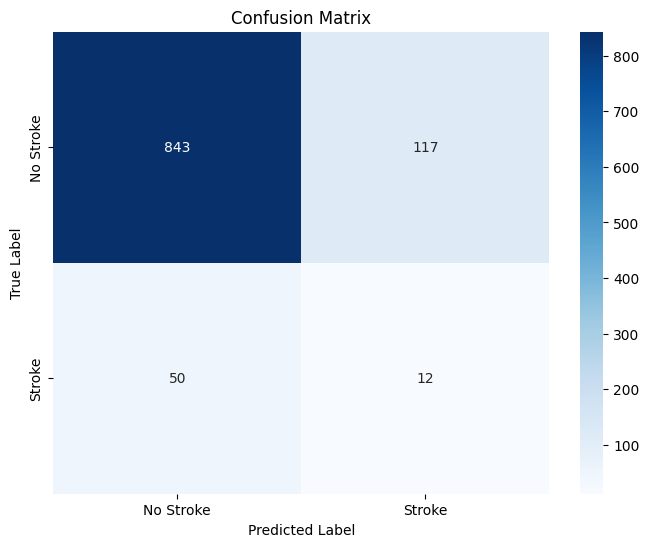


Detailed Metrics:
Accuracy Score: 0.837
F1 Score: 0.126


In [58]:
# Print evaluation metrics
print("\nModel Evaluation Results:")
print("-" * 50)
print(f"Best Classification Threshold: {best_threshold:.3f}")

# Convert y_test to numpy array once for all metrics
y_test_numpy = y_test.cpu().numpy()

print("\nClassification Report:")
print(classification_report(y_test_numpy, y_pred))
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_numpy, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


print("\nDetailed Metrics:")
print(f"Accuracy Score: {accuracy_score(y_test_numpy, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test_numpy, y_pred):.3f}")

# FocalLoss class remains the same
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)

# Use focal loss instead of BCE
criterion = FocalLoss(alpha=2, gamma=3)

In [27]:
#Fully connected Neural Network
# Create PyTorch Dataset
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class FCNN(nn.Module):
    def __init__(self, input_size=3*32*32, hidden_sizes=[512, 256, 128], num_classes=1):
        super(FCNN, self).__init__()
        
        # Create layers list to hold all linear layers
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))
        
        # Hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        layers.append(nn.Sigmoid())
        
        # Combine all layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)
        return self.model(x)


def get_fcnn():
    """
    Returns an instance of the FCNN model.
    """
    return FCNN()


In [28]:

# Create data loaders
train_dataset = StrokeDataset(X_train_balanced, y_train_balanced)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Add this before model initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Add this after device initialization
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Calculate class weights more precisely
class_weights = torch.FloatTensor([1.0, 12.0]).to(device)
criterion = nn.BCELoss(weight=class_weights[1])

# Initialize model with improved optimizer settings
model = FCNN(len(features)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.005)

# Define num_epochs first
num_epochs = 100

# Move scheduler initialization after num_epochs definition
scheduler = lr_scheduler.OneCycleLR(optimizer, 
                                  max_lr=0.001,
                                  epochs=num_epochs,
                                  steps_per_epoch=len(train_loader),
                                  pct_start=0.2)

# Add validation set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32)

# Training loop with early stopping
best_loss = float('inf')
patience_counter = 0
early_stopping_patience = 15

# Modify training loop with gradient accumulation
accumulation_steps = 4

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 Ti


In [ ]:
# 3. Modified training loop with detailed monitoring
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            
            preds = (outputs.squeeze() > 0.5).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(batch_y.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    f1 = f1_score(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, all_preds)
    
    return avg_loss, f1, accuracy

# Add lists to store metrics
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []

# Modified training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    
    for i, (batch_X, batch_y) in enumerate(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        train_loss += loss.item()
    
    # Calculate and store metrics every epoch
    avg_train_loss, train_f1, train_acc = evaluate_model(model, train_loader, criterion, device)
    avg_val_loss, val_f1, val_acc = evaluate_model(model, val_loader, criterion, device)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    
    # Print detailed metrics every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        print("-" * 50)
        print(f"Training   - Loss: {avg_train_loss:.4f}, F1: {train_f1:.4f}, Acc: {train_acc:.4f}")
        print(f"Validation - Loss: {avg_val_loss:.4f}, F1: {val_f1:.4f}, Acc: {val_acc:.4f}")
    
    # Early stopping check
    avg_val_loss, _, _ = evaluate_model(model, val_loader, criterion, device)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break


Epoch [10/100]
--------------------------------------------------
Training   - Loss: 4.8801, F1: 0.8320, Acc: 0.8194
Validation - Loss: 4.8445, F1: 0.8368, Acc: 0.8205

Epoch [20/100]
--------------------------------------------------
Training   - Loss: 3.6641, F1: 0.8806, Acc: 0.8710
Validation - Loss: 3.6234, F1: 0.8867, Acc: 0.8750

Epoch [30/100]
--------------------------------------------------
Training   - Loss: 2.5294, F1: 0.9248, Acc: 0.9229
Validation - Loss: 2.4920, F1: 0.9244, Acc: 0.9205

Epoch [40/100]
--------------------------------------------------
Training   - Loss: 1.7975, F1: 0.9469, Acc: 0.9447
Validation - Loss: 1.6853, F1: 0.9500, Acc: 0.9468

Epoch [50/100]
--------------------------------------------------
Training   - Loss: 1.4411, F1: 0.9570, Acc: 0.9554
Validation - Loss: 1.3568, F1: 0.9618, Acc: 0.9596

Epoch [60/100]
--------------------------------------------------
Training   - Loss: 1.1502, F1: 0.9670, Acc: 0.9662
Validation - Loss: 1.0561, F1: 0.9730

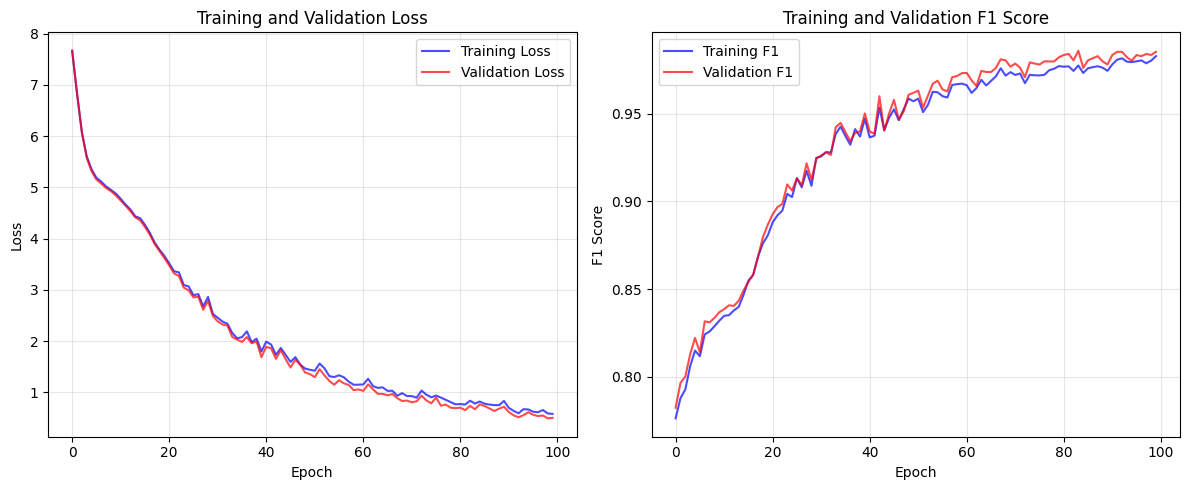


Training visualization has been saved as 'training_metrics.png'


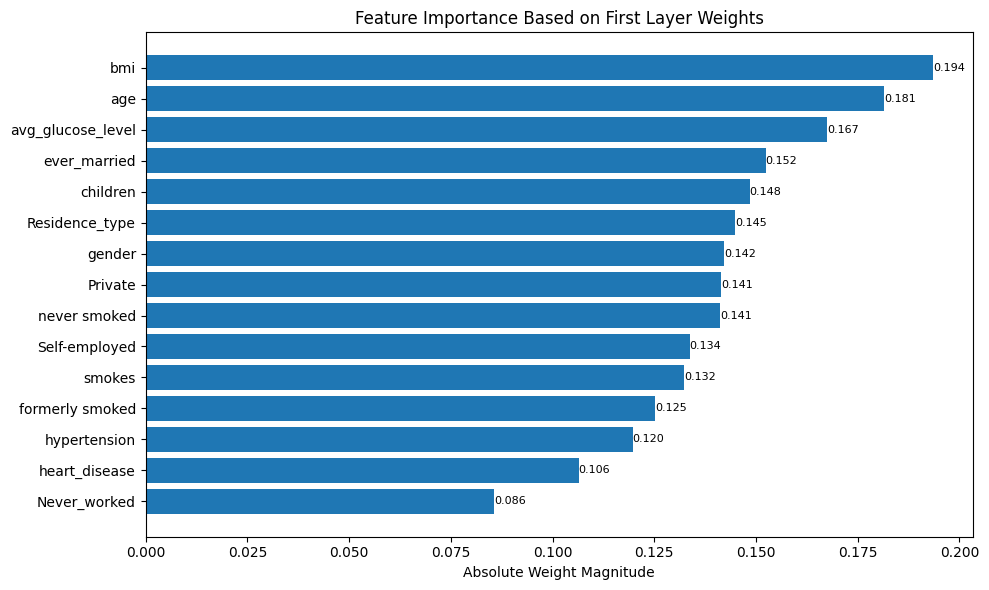


Feature importance visualization has been saved as 'feature_importance.png'


In [51]:
# Add visualization after training
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Training F1', color='blue', alpha=0.7)
plt.plot(val_f1s, label='Validation F1', color='red', alpha=0.7)
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()  # This will display the plot in addition to saving it

print("\nTraining visualization has been saved as 'training_metrics.png'")

# Add feature importance visualization
def plot_feature_importance(model, feature_names):
    # Get the weights from the first layer
    first_layer_weights = abs(model.input_layer[0].weight.data.cpu().numpy())
    
    # Calculate importance scores (mean absolute weight for each feature)
    importance_scores = np.mean(first_layer_weights, axis=0)
    
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    
    # Plot
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(feature_importance)), feature_importance['Importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Absolute Weight Magnitude')
    plt.title('Feature Importance Based on First Layer Weights')
    
    # Add value labels on the bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function after training
plot_feature_importance(model, features)
print("\nFeature importance visualization has been saved as 'feature_importance.png'")


Model Evaluation Results:
--------------------------------------------------
Best Classification Threshold: 0.500

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.03      0.07       960
         1.0       0.06      0.98      0.12        62

    accuracy                           0.09      1022
   macro avg       0.52      0.51      0.09      1022
weighted avg       0.92      0.09      0.07      1022



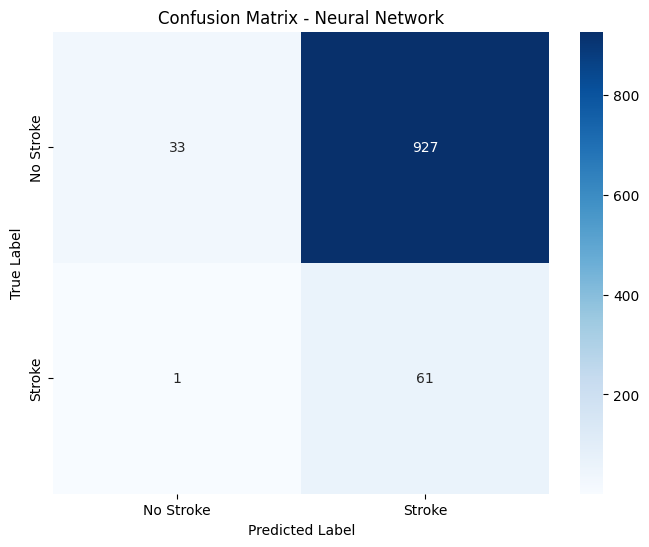


Confusion Matrix:

Raw numbers:
True Negatives  (TN): 33
False Positives (FP): 927
False Negatives (FN): 1
True Positives  (TP): 61


Detailed Metrics:
Accuracy Score: 0.092
F1 Score: 0.116

Model Size:
Number of parameters: 1,756,417
Memory footprint: 6.731 MB


In [52]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Add focal loss option
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)
# Check if inputs are already tensors and move them to device
X_train_balanced = X_train_balanced.to(device) if torch.is_tensor(X_train_balanced) else torch.FloatTensor(X_train_balanced).to(device)
y_train_balanced = y_train_balanced.to(device) if torch.is_tensor(y_train_balanced) else torch.FloatTensor(y_train_balanced).to(device)
X_test_scaled = X_test_scaled.to(device) if torch.is_tensor(X_test_scaled) else torch.FloatTensor(X_test_scaled).to(device)
y_test = y_test.to(device) if torch.is_tensor(y_test) else torch.FloatTensor(y_test.values).to(device)


# Create PyTorch Dataset
class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create data loaders
train_dataset = StrokeDataset(X_train_balanced, y_train_balanced)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model and move to device
model = StrokePredictor(len(features)).to(device)

# Move class weights to device
class_weights = torch.FloatTensor([1.0, 12.0]).to(device)
criterion = FocalLoss(alpha=2, gamma=3).to(device)

# Modified evaluation function
def evaluate_with_threshold_tuning(model, X_test, y_test, thresholds=np.arange(0.1, 0.9, 0.1)):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).cpu().numpy()
    
    y_test_numpy = y_test.cpu().numpy()
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (predictions > threshold).astype(int)
        f1 = f1_score(y_test_numpy, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

best_threshold = evaluate_with_threshold_tuning(model, X_test_scaled, y_test)

# Final evaluation with best threshold
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_scaled).cpu().numpy()
    y_pred = (test_predictions > best_threshold).astype(int)

# Convert y_test to numpy once for all evaluations
y_test_numpy = y_test.cpu().numpy()

# Print evaluation metrics
print("\nModel Evaluation Results:")
print("-" * 50)
print(f"Best Classification Threshold: {best_threshold:.3f}")

print("\nClassification Report:")
print(classification_report(y_test_numpy, y_pred))

# Create and display confusion matrix
conf_matrix = confusion_matrix(y_test_numpy, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Confusion Matrix - Neural Network')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nConfusion Matrix:")
print(f"""
Raw numbers:
True Negatives  (TN): {conf_matrix[0][0]}
False Positives (FP): {conf_matrix[0][1]}
False Negatives (FN): {conf_matrix[1][0]}
True Positives  (TP): {conf_matrix[1][1]}
""")

print("\nDetailed Metrics:")
print(f"Accuracy Score: {accuracy_score(y_test_numpy, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test_numpy, y_pred):.3f}")

# Rest of your code remains the same
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return torch.mean(focal_loss)

# Use focal loss instead of BCE
criterion = FocalLoss(alpha=2, gamma=3)

# Move data to device
X_train_balanced = X_train_balanced.to(device)
y_train_balanced = y_train_balanced.to(device)
X_test_scaled = X_test_scaled.to(device)
y_test = y_test.to(device)

def print_model_size(model):
    param_size = 0
    buffer_size = 0
    
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
        
    size_all_mb = (param_size + buffer_size) / 1024**2
    
    print(f'\nModel Size:')
    print(f'Number of parameters: {sum(p.numel() for p in model.parameters()):,}')
    print(f'Memory footprint: {size_all_mb:.3f} MB')

# Call this after model creation
print_model_size(model)